Trabajo Practico 2

In [29]:
# LIBRERIAS
import numpy as np
from PIL import Image
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

1. Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.
a) Verifique si la red aprendió las imágenes enseñadas.
b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes
aprendidas: agregado de ruido, elementos borrados o agregados.
c) Evalúe la existencia de estados espurios en la red: patrones inversos y
combinaciones de un número impar de patrones. (Ver Spurious States, en la sección
2.2, Hertz, Krogh & Palmer, pág. 24).
d) Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de
aprender todas las imágenes? Explique.

In [51]:
# FUNCIONES

def patternToBMPImage(S, width, height):
    if len(S) > width * height:
        S = S[:width * height]
    imgArray = np.reshape(S, (height, width))  # Ajustar a (alto, ancho)
    imgArray = imgArray + np.ones((height, width))
    imgArray = (imgArray * 127.5).astype(np.uint8)  # Convertir de 0/1 a 0/255

    return Image.fromarray(imgArray)

def showImageProgress(input, height, width, t):
    currentImg = patternToBMPImage(input, width, height)
    display(currentImg)
    time.sleep(t * 1e-3)
    clear_output(wait=True)

def hopfieldUpdateSync(weights, input, index):
    localField = np.dot(weights[index], input)
    newState = np.sign(localField)
    if newState == 0:
        newState = 1
    hasUpdated = newState != input[index]
    input[index] = newState

    return hasUpdated

def hopfieldSync(W, input, height=0, width=0, show=False, t=1):
    N = height * width
    updates = 0

    for i in range(len(input)):
        update = hopfieldUpdateSync(W, input, i)
        updates += update
        if update and show and N != 0:
            showImageProgress(input, height, width, t)
    if show and updates > 0:
        time.sleep(1.5)

    return updates

def hopfieldUpdateUnsync(weights, input, index):
    localField = np.dot(weights[index], input)
    newState = np.sign(localField)
    if newState == 0:
        newState = 1
    hasUpdated = newState != input[index]
    input[index] = newState
    
    return hasUpdated

def hopfieldUnsync(weights, input, height=0, width=0, show=False, t=1):
    length = len(input)
    N = height * width
    updates = 0
    randomUpdateIndexes = np.random.permutation(length)

    for i in range(length):
        update = hopfieldUpdateUnsync(weights, input, randomUpdateIndexes[i])
        updates += update
        if update and show and N != 0:
            showImageProgress(input, height, width, t)

    if show and updates > 0:
        time.sleep(1.5)

    return updates

# Carga una imagen y la combierte a un patron
def loadImageAndConvertToPattern(path):
    image = Image.open(path).convert('1')  # Convertir a unos y ceros
    vector = np.array(image).astype(int) 
    vector = vector.flatten() # Imagen como vector
    pattern =  2 * vector - 1 # Patrones de -1 o 1

    return image, pattern

# Muestra imagenes
def showImages(images):
    for img in images:
        display(img)


# Arma la matriz de pesos
def computeWeights(patterns):
    length = len(patterns[0])
    weights = np.zeros((length, length), float)

    for pattern in patterns:
        weights += np.outer(pattern, pattern)

    return weights - len(patterns) * np.eye(length) # Elimino la diagonal para pesos de autoconexiones

Imagen original 1:


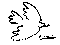

Imagen recuperada 1:


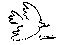

La red aprendió la imagen 1 suministrada.
Imagen original 2:


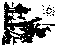

Imagen recuperada 2:


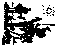

La red aprendió la imagen 2 suministrada.
Imagen original 3:


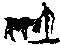

Imagen recuperada 3:


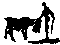

La red aprendió la imagen 3 suministrada.


In [55]:
# VERIFICACION DE APRENDIZAJE

# Imagenes 45x60
paths45x60 = ['ImgTP2/paloma.bmp', 'ImgTP2/quijote.bmp', 'ImgTP2/torero.bmp']

# Imagenes 50x50
paths50x50 = ['ImgTP2/panda.bmp', 'ImgTP2/perro.bmp', 'ImgTP2/v.bmp']

# Convertir a patron
images45x60, patterns45x60 = zip(*(loadImageAndConvertToPattern(path) for path in paths45x60))
images50x50, patterns50x50 = zip(*(loadImageAndConvertToPattern(path) for path in paths50x50))

# Selecciono las imagenes a aprender
#images = images50x50
#patterns = patterns50x50
images = images45x60
patterns = patterns45x60

[width, height] = images[0].size

weights = computeWeights(patterns)
inputs = [pattern.copy() for pattern in patterns]
sync = True

for i, input in enumerate(inputs):
    print(f"Imagen original {i+1}:")
    display(images[i])

    show = True
    updates = 0

    if sync:
        updates = hopfieldSync(weights, input, height, width, show)
    else:
        updates = hopfieldUnsync(weights, input, height, width, show)
    
    print(f"Imagen recuperada {i+1}:")
    recoveredImage = patternToBMPImage(input, width, height)
    display(recoveredImage)

    if updates == 0:
        print(f'La red aprendió la imagen {i+1} suministrada.')
        time.sleep(1)


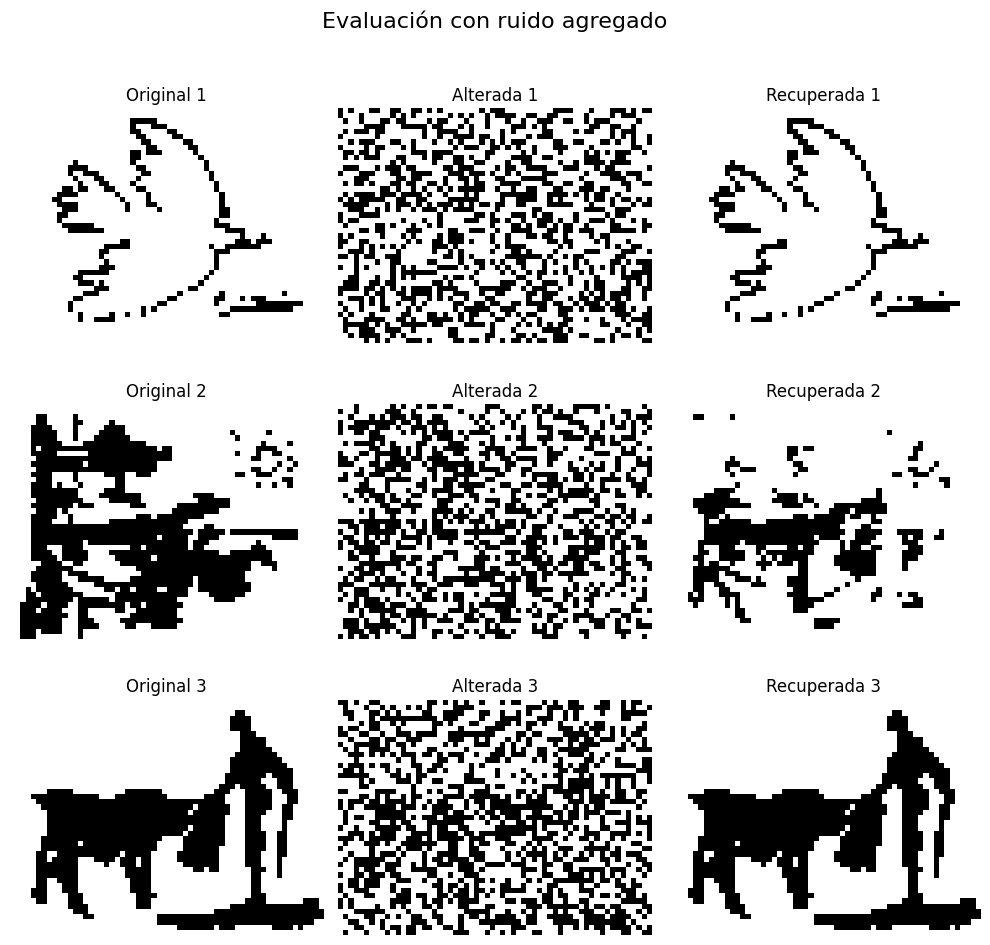

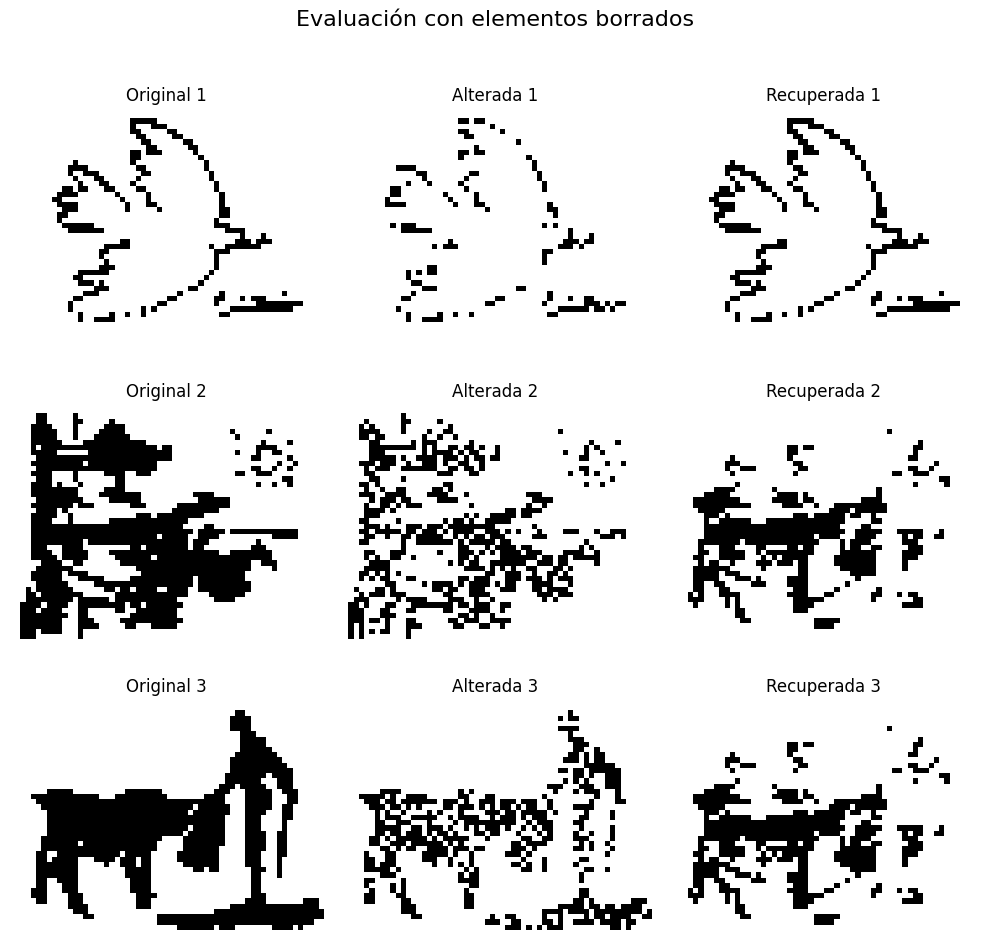

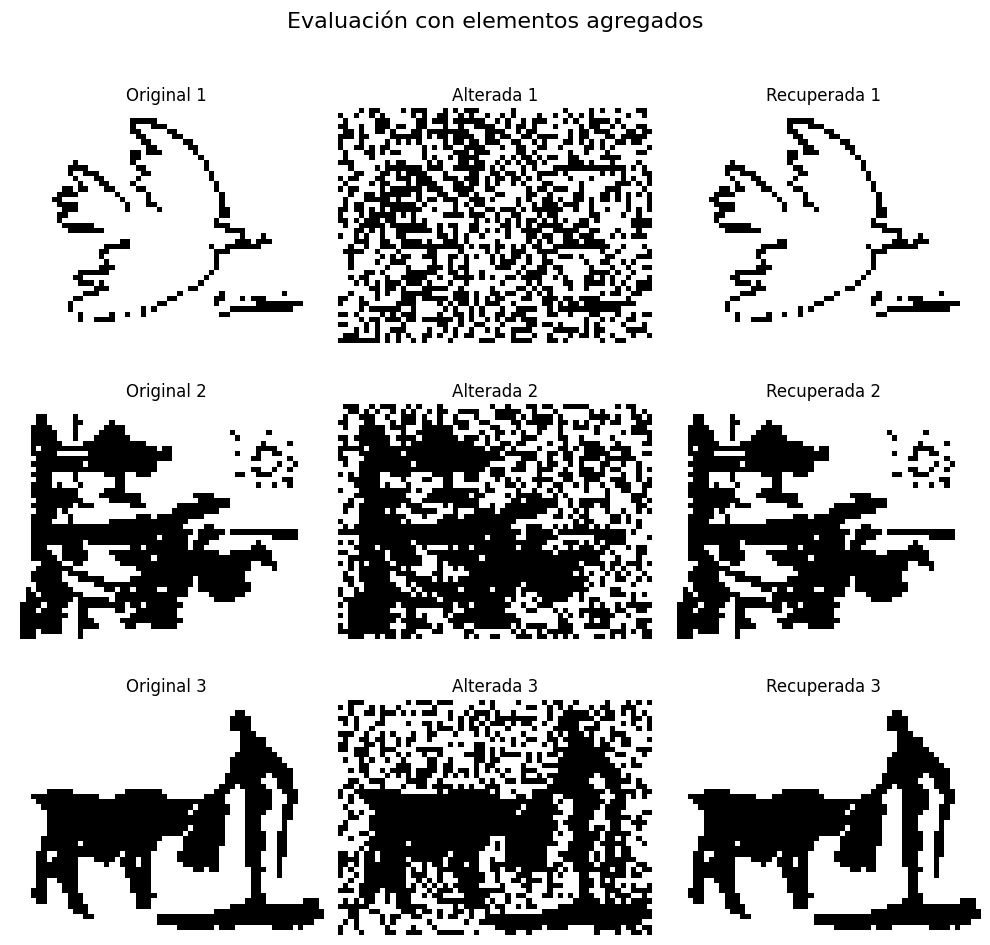

In [56]:
# VARIACIONES

def addNoise(pattern, noise_level=0.1):
    """
    Agrega ruido al patrón.
    noise_level: proporción de elementos que se van a cambiar.
    """
    noisy_pattern = pattern.copy()
    num_noisy_elements = int(noise_level * len(pattern))
    noisy_indices = np.random.choice(len(pattern), num_noisy_elements, replace=False)
    noisy_pattern[noisy_indices] *= -1  # Invertir el estado de los elementos seleccionados

    return noisy_pattern

def removeElements(pattern, removal_level=0.1):
    """
    Borra elementos del patrón (los pone a cero).
    removal_level: proporción de elementos que se van a borrar.
    """
    removed_pattern = pattern.copy()
    num_removed_elements = int(removal_level * len(pattern))
    removed_indices = np.random.choice(len(pattern), num_removed_elements, replace=False)
    for idx in removed_indices:
        if removed_pattern[idx] == -1:
            removed_pattern[idx] = 1
    #removed_pattern[removed_indices] = 0  # Pone a cero los elementos seleccionados

    return removed_pattern

def addElements(pattern, addition_level=0.1):
    """
    Agrega elementos al patrón (pone algunos a 1 si están en -1 o viceversa).
    addition_level: proporción de elementos que se van a agregar.
    """
    added_pattern = pattern.copy()
    num_added_elements = int(addition_level * len(pattern))
    added_indices = np.random.choice(len(pattern), num_added_elements, replace=False)
    for idx in added_indices:
        if added_pattern[idx] == 1:
            added_pattern[idx] = -1

    return added_pattern

# Evaluar la evolución de la red con versiones alteradas de las imágenes

def evaluateNetworkAlteredImages2(weights, patterns, height, width, alteration_fn, alteration_level=0.1, sync=True):
    """
    Evalúa la red de Hopfield con versiones alteradas de los patrones.
    alteration_fn: función para alterar el patrón.
    alteration_level: nivel de alteración.
    """
    altered_patterns = [alteration_fn(pattern, alteration_level) for pattern in patterns]
    
    for i, (original_pattern, altered_pattern) in enumerate(zip(patterns, altered_patterns)):
        print(f"Imagen original {i+1}:")
        original_image = patternToBMPImage(original_pattern, width, height)
        display(original_image)
        print(original_pattern)
        time.sleep(1)

        print(f"Imagen alterada {i+1}:")
        altered_image = patternToBMPImage(altered_pattern, width, height)
        display(altered_image)
        time.sleep(1)

        show = False
        updates = 0

        input_pattern = altered_pattern.copy()
        
        if sync:
            updates = hopfieldSync(weights, input_pattern, height, width, show)
        else:
            updates = hopfieldUnsync(weights, input_pattern, height, width, show)

        print(f"Imagen recuperada de la imagen alterada {i+1}:")
        recovered_image = patternToBMPImage(input_pattern, width, height)
        display(recovered_image)
        time.sleep(1)
    return updates

def evaluateNetworkAlteredImages(weights, patterns, height, width, alteration_fn, alteration_level=0.1, sync=True, title="Evaluación"):
    altered_patterns = [alteration_fn(pattern, alteration_level) for pattern in patterns]
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    row = 0

    for i, (original_pattern, altered_pattern) in enumerate(zip(patterns, altered_patterns)):
        original_image = patternToBMPImage(original_pattern, width, height)
        altered_image = patternToBMPImage(altered_pattern, width, height)
        input_pattern = altered_pattern.copy()
        
        if sync:
            hopfieldSync(weights, input_pattern, height, width, show=False)
        else:
            hopfieldUnsync(weights, input_pattern, height, width, show=False)
        
        recovered_image = patternToBMPImage(input_pattern, width, height)
        
        # Mostrar las imágenes en el gráfico
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].set_title(f'Original {i+1}')
        axes[row, 0].axis('off')
        axes[row, 1].imshow(altered_image, cmap='gray')
        axes[row, 1].set_title(f'Alterada {i+1}')
        axes[row, 1].axis('off')
        axes[row, 2].imshow(recovered_image, cmap='gray')
        axes[row, 2].set_title(f'Recuperada {i+1}')
        axes[row, 2].axis('off')
        row = row + 1
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Variables para los títulos
title_noise = "Evaluación con ruido agregado"
title_removal = "Evaluación con elementos borrados"
title_addition = "Evaluación con elementos agregados"

# Evaluar la red con versiones alteradas de las imágenes

# Parámetros de alteración
noise_level = 0.4
removal_level = 0.4
addition_level = 0.4

# Agregar ruido a las imágenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, addNoise, noise_level, sync, title_noise)

# Borrar elementos de las imágenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, removeElements, removal_level, sync, title_removal)

# Agregar elementos a las imágenes aprendidas
evaluateNetworkAlteredImages(weights, patterns, height, width, addElements, addition_level, sync, title_addition)


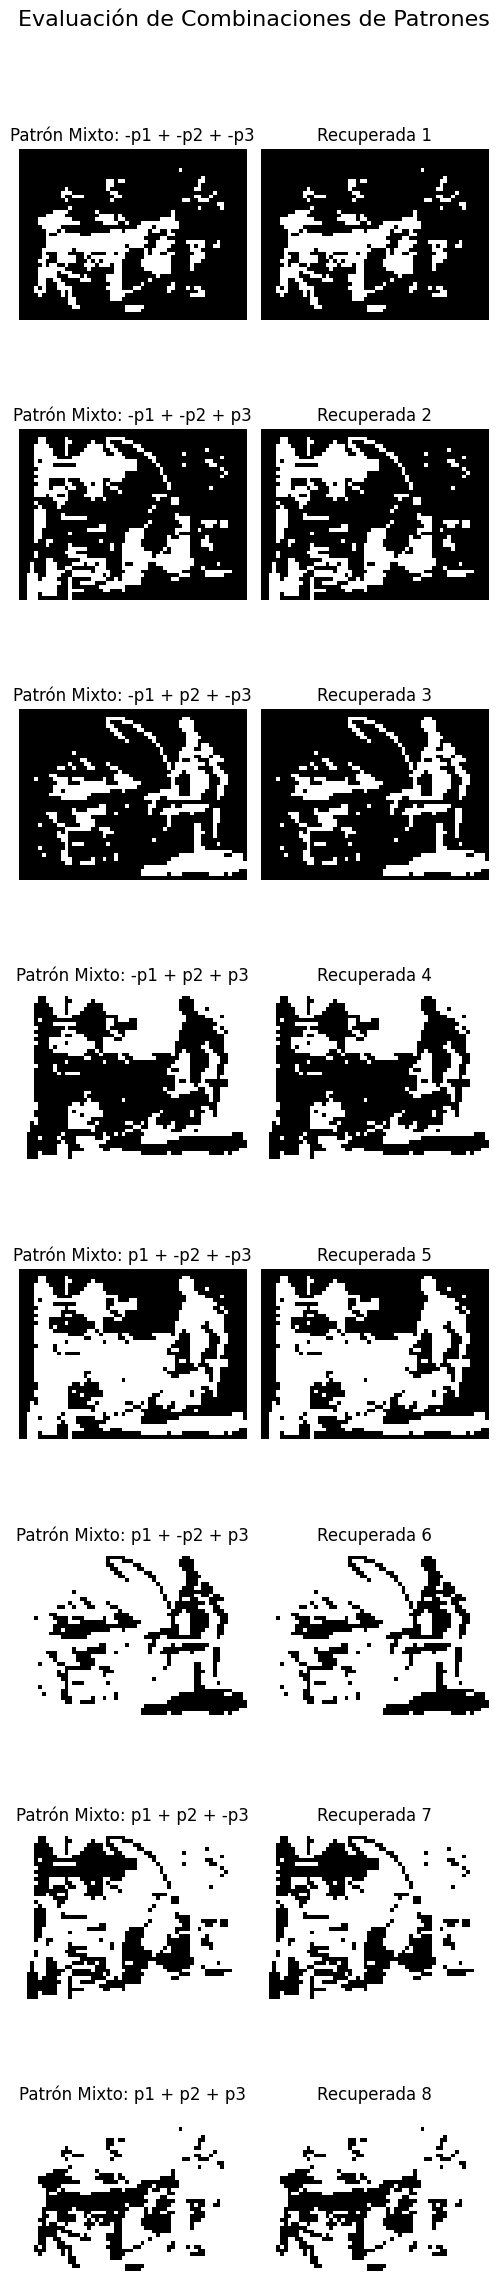

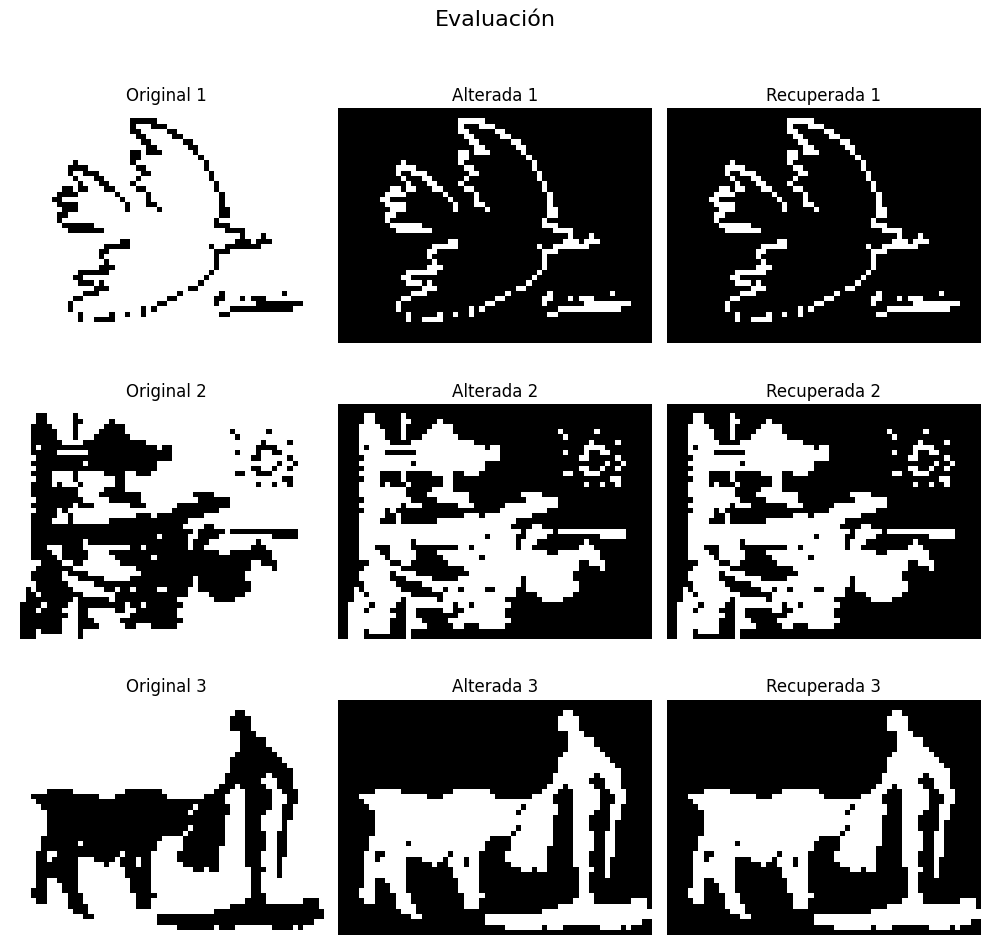

In [57]:
# Funciones para generar estados espurios

def generateInversePattern(pattern, alteration_level):
    """
    Genera el patrón inverso.
    """
    return -pattern

def generateMixturePattern(patterns):
    """
    Genera una combinación de un número impar de patrones.
    """
    combined_pattern = np.sign(np.sum(patterns, axis=0))
    return combined_pattern
from itertools import product

def generateAllMixturePatterns(patterns):
    """
    Genera todas las combinaciones posibles de un número impar de patrones
    utilizando sumas y restas.
    """
    num_patterns = len(patterns)
    all_combinations = []

    # Generar todas las combinaciones de signos para los patrones
    for signs in product([-1, 1], repeat=num_patterns):
        # Solo queremos combinaciones de un número impar de signos positivos
        if sum(signs) % 2 == 1:
            combined_pattern = np.sign(np.sum([sign * pattern for sign, pattern in zip(signs, patterns)], axis=0))
            all_combinations.append((signs, combined_pattern))

    return all_combinations

def evaluateAllMixturePatterns(weights, patterns, height, width, sync=True, title="Evaluación de Combinaciones de Patrones"):
    mixture_patterns = generateAllMixturePatterns(patterns)
    
    fig, axes = plt.subplots(len(mixture_patterns), 2, figsize=(5, 3 * len(mixture_patterns)))
    fig.suptitle(title, fontsize=16)

    for i, (signs, mixture_pattern) in enumerate(mixture_patterns):
        combination_detail = ' + '.join([f'{"-" if sign == -1 else ""}p{j+1}' for j, sign in enumerate(signs)])
        altered_image = patternToBMPImage(mixture_pattern, width, height)
        input_pattern = mixture_pattern.copy()
        
        if sync:
            hopfieldSync(weights, input_pattern, height, width, show=False)
        else:
            hopfieldUnsync(weights, input_pattern, height, width, show=False)
        
        recovered_image = patternToBMPImage(input_pattern, width, height)
        
        # Mostrar las imágenes en el gráfico
        axes[i, 0].imshow(altered_image, cmap='gray')
        axes[i, 0].set_title(f'Patrón Mixto: {combination_detail}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(recovered_image, cmap='gray')
        axes[i, 1].set_title(f'Recuperada {i+1}')
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()



# Variables para los títulos
title_inverse = "Evaluación de Patrones Inversos"
title_mixture = "Evaluación de Combinaciones de Patrones"

# Evaluar la red con combinaciones de patrones
evaluateAllMixturePatterns(weights, patterns, height, width, sync, title_mixture)

# Variables para los títulos
title_spurious = "Evaluación de Estados Espurios"

# Evaluar la red con estados espurios
#evaluateSpuriousStates(weights, patterns, height, width, sync, title_spurious)

# Variables para los títulos
title_inverse = "Evaluación de Estados Espurios - Patrones inversos"

# Evaluar la red con estados espurios
evaluateNetworkAlteredImages(weights, patterns, height, width, generateInversePattern, title_inverse)

Imagen original 1:


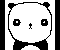

0.0
Imagen recuperada 1:


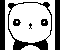

La red aprendió la imagen 1 suministrada.
Imagen original 2:


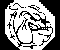

0.0
Imagen recuperada 2:


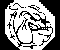

La red aprendió la imagen 2 suministrada.
Imagen original 3:


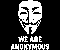

0.0
Imagen recuperada 3:


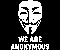

La red aprendió la imagen 3 suministrada.
Imagen original 4:


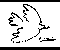

3.066666666666667
Imagen recuperada 4:


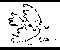

Imagen original 5:


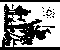

2.1
Imagen recuperada 5:


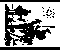

Imagen original 6:


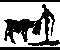

0.0
Imagen recuperada 6:


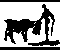

La red aprendió la imagen 6 suministrada.


In [72]:
from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt

def padImage(image, target_width, target_height):
    """
    Rellena la imagen con bordes para que tenga el tamaño objetivo.
    """
    delta_width = target_width - image.width
    delta_height = target_height - image.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    return ImageOps.expand(image, padding, fill=0)

def resizeImagesToCommonSize(images):
    """
    Encuentra el tamaño máximo y redimensiona todas las imágenes a ese tamaño.
    """
    max_width = max(image.width for image in images)
    max_height = max(image.height for image in images)
    
    resized_images = [padImage(image, max_width, max_height) for image in images]
    return resized_images, max_width, max_height

def imageToPattern(img):
    """
    Convierte una imagen en un patrón binario (-1 y 1).
    """
    vector = np.array(img).astype(int)
    vector = vector.flatten()

    # Convertir los valores de 0 (negro) a -1 y 255 (blanco) a 1
    return 2 * vector - 1

# Paths de las imágenes 45x60 y 50x50
paths45x60 = ['ImgTP2/paloma.bmp', 'ImgTP2/quijote.bmp', 'ImgTP2/torero.bmp']
paths50x50 = ['ImgTP2/panda.bmp', 'ImgTP2/perro.bmp', 'ImgTP2/v.bmp']

# Cargar y convertir las imágenes a patrones
images45x60, patterns45x60 = zip(*(loadImageAndConvertToPattern(path) for path in paths45x60))
images50x50, patterns50x50 = zip(*(loadImageAndConvertToPattern(path) for path in paths50x50))

# Combinar las imágenes
images = list(images50x50) + list(images45x60)

# Redimensionar todas las imágenes a un tamaño común
resized_images, common_width, common_height = resizeImagesToCommonSize(images)

[width, height] = resized_images[0].size

# Convertir las imágenes redimensionadas a patrones
patterns = [imageToPattern(image) for image in resized_images]


# Calcular la matriz de pesos utilizando la regla de Hebb
weights = computeWeights(patterns)

inputs = [pattern.copy() for pattern in patterns]
sync = True

for i, input in enumerate(inputs):
    print(f"Imagen original {i+1}:")
    display(resized_images[i])

    show = False
    updates = 0

    if sync:
        updates = hopfieldSync(weights, input, height, width, show)
        print(100*updates/(60*50))
    else:
        updates = hopfieldUnsync(weights, input, height, width, show)
    
    print(f"Imagen recuperada {i+1}:")
    recoveredImage = patternToBMPImage(input, width, height)
    display(recoveredImage)

    if updates == 0:
        print(f'La red aprendió la imagen {i+1} suministrada.')
        time.sleep(1)


2.
a) Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la
cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño
de la red. Obtener experimentalmente los resultados de la siguiente tabla (los
valores de la tabla corresponden a una iteración con actualización sincrónica).
        Perror  pmax/N
        0,001   0,105
        0,0036  0,138
        0,01    0,185
        0,05    0,37
        0,1     0,61
(Tabla 2.1, sección 2.2, Hertz, Krogh & Palmer, pág. 19)
b) Analice cómo cambia la capacidad de una red en función de la correlación entre 
patrones